## Download Data

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dschettler8845/brats-2021-task1

100% 12.3G/12.3G [36:35<00:00, 7.04MB/s]
100% 12.3G/12.3G [36:35<00:00, 6.01MB/s]


In [ ]:
! unzip "/content/brats-2021-task1.zip" 

Archive:  /content/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


In [ ]:
fname =  "/content/BraTS2021_Training_Data.tar"

import tarfile

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall("/content/out/")
    tar.close()

In [ ]:
len(os.listdir(out))

## Libraries

In [17]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
# from monai.networks.nets import VNet
# from monai.metrics import DiceMetric
# from monai.losses import DiceLoss
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm
from torchsummary import summary
import nibabel as nib
import cv2
# from pytorch_lightning import Trainer


In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator


In [ ]:
! pip install pytorch_lightning

In [ ]:
! pip install transformers

## Dataset

In [ ]:
class BraTSDataset(Dataset):

    def __init__(self, path, transform=None):
        """
        Args:
            images_path (string): Path to input images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        self.transform = transform
        self.cases_list = os.listdir(path)



    def __len__(self):
        return len(self.cases_list)

    def __getitem__(self, idx):
        image_name = self.cases_list[idx]
        
        image_path = self.path + "/" + image_name +"/" +image_name + "_flair.nii"
        image =  nib.load(image_path)
        image = image.get_fdata()
        min_ = image.min()
        max_ = image.max()
        image = (image - min_)/(max_ - min_)
        image = np.float32(image)
        # image = np.expand_dims(image, axis = -1)
        #--------------------------------------------------
        mask_path = self.path + "/" + image_name +"/" + image_name + "_seg.nii"
        mask =  nib.load(mask_path)
        mask = mask.get_fdata()
        min_ = mask.min()
        max_ = mask.max()
        mask = (mask - min_)/(max_ - min_)
        mask = np.float32(mask)
        # mask = np.expand_dims(mask, axis = -1)


        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w, z = image.shape[:3]
        
        new_h, new_w, new_z = self.output_size

        new_h, new_w, new_z = int(new_h), int(new_w), int(new_z)

        img = transform.resize(image, (new_h, new_w, new_z))
        mask = transform.resize(mask, (new_h, new_w, new_z))
        # img = np.stack((img,)*3, axis=-1)

        return {'image': img, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

In [ ]:
train = BraTSDataset(path='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData',
                                    transform=transforms.Compose([
                                        # Rescale((256,256,128)),
                                        ToTensor()
                                           ]))


val = BraTSDataset(path='/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData',
                                    transform=transforms.Compose([
                                        # Rescale((256,256,128)),
                                        ToTensor()
                                           ]))


sample = train[3]
# print(sample)
print(sample['image'].shape, sample['mask'].shape)


torch.Size([155, 240, 240]) torch.Size([155, 240, 240])


In [ ]:
print(len(train))
print(len(val))

371
127


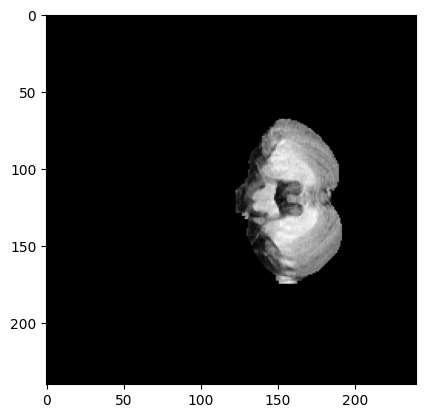

In [ ]:
sample = train[50]
plt.imshow(sample['image'][20,:,:], cmap = "gray")

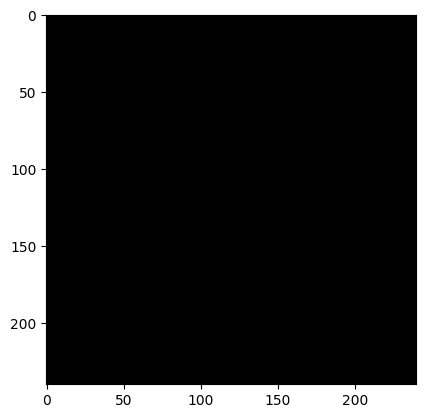

In [ ]:
plt.imshow(sample['mask'][20,:,:], cmap = "gray")

In [ ]:
train_loader = DataLoader(train, batch_size=4,
                        shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=4,
                        shuffle=True, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
    if i_batch == 2: break

0 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])
1 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])
2 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Testing SAM

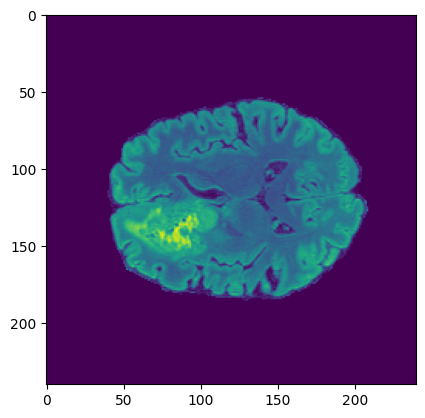

In [ ]:
image_path = "/content/BraTS2021_00000/BraTS2021_00000_flair.nii.gz"

image =  nib.load(image_path)
image = image.get_fdata()
min_ = image.min()
max_ = image.max()
image = (image - min_)/(max_ - min_)
image = np.float32(image)

plt.imshow(image[:,:,80])

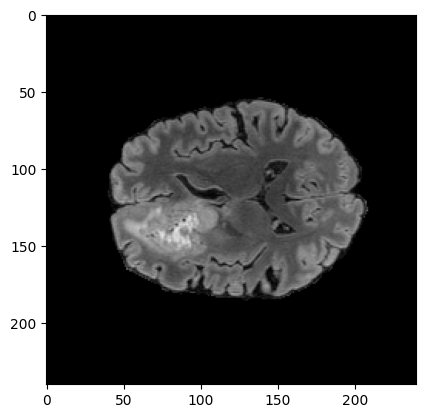

In [ ]:
image = cv2.cvtColor(image[:,:,80], cv2.COLOR_BGR2RGB)
image = image * 255
image = np.uint8(image)
plt.imshow(image)

In [ ]:
image.shape

(240, 240, 3)

### Bounding Boxes

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
input_box = np.array([0, 0, 240, 240])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

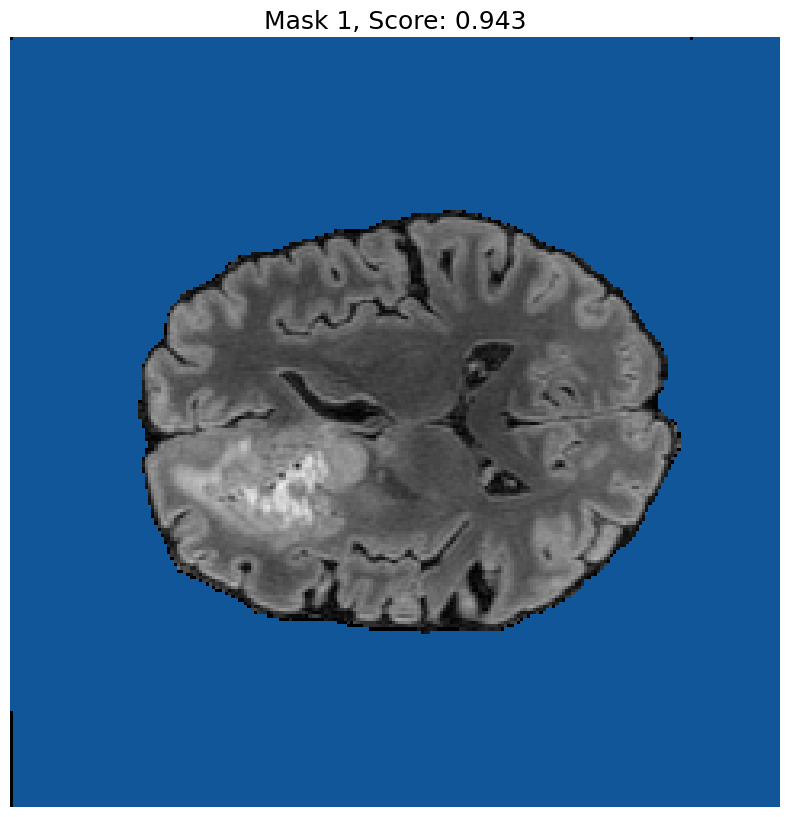

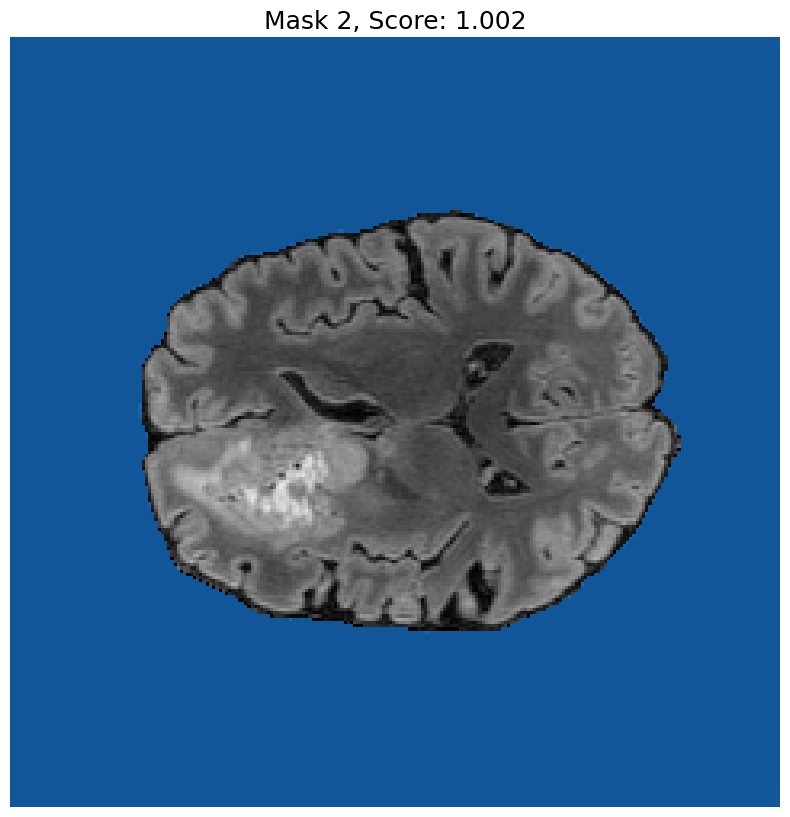

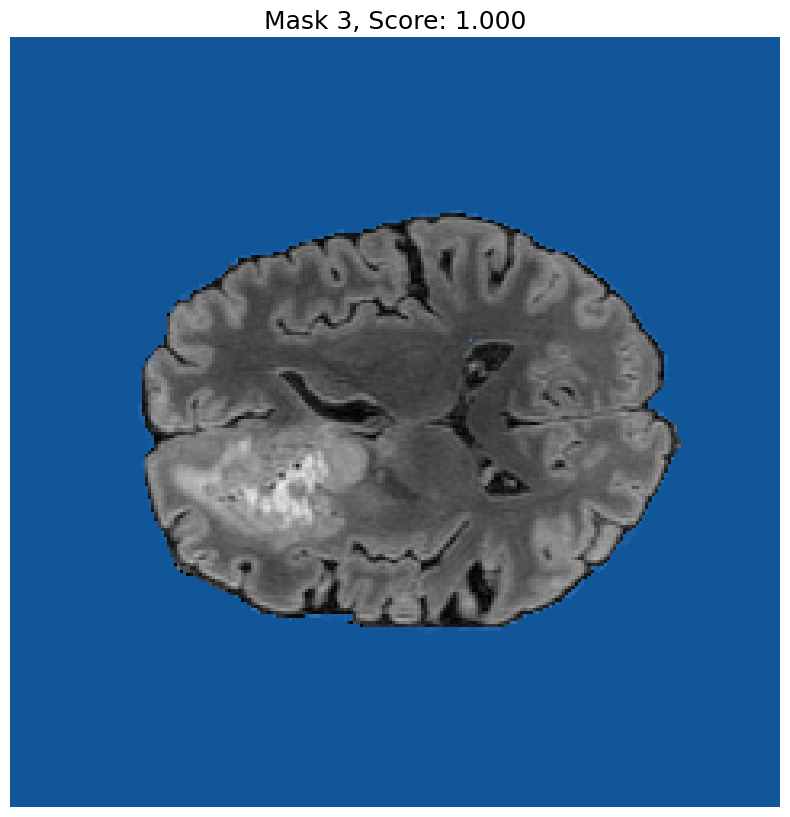

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

### Segment everything

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)


In [ ]:
print(len(masks))
print(masks[0].keys())

13
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


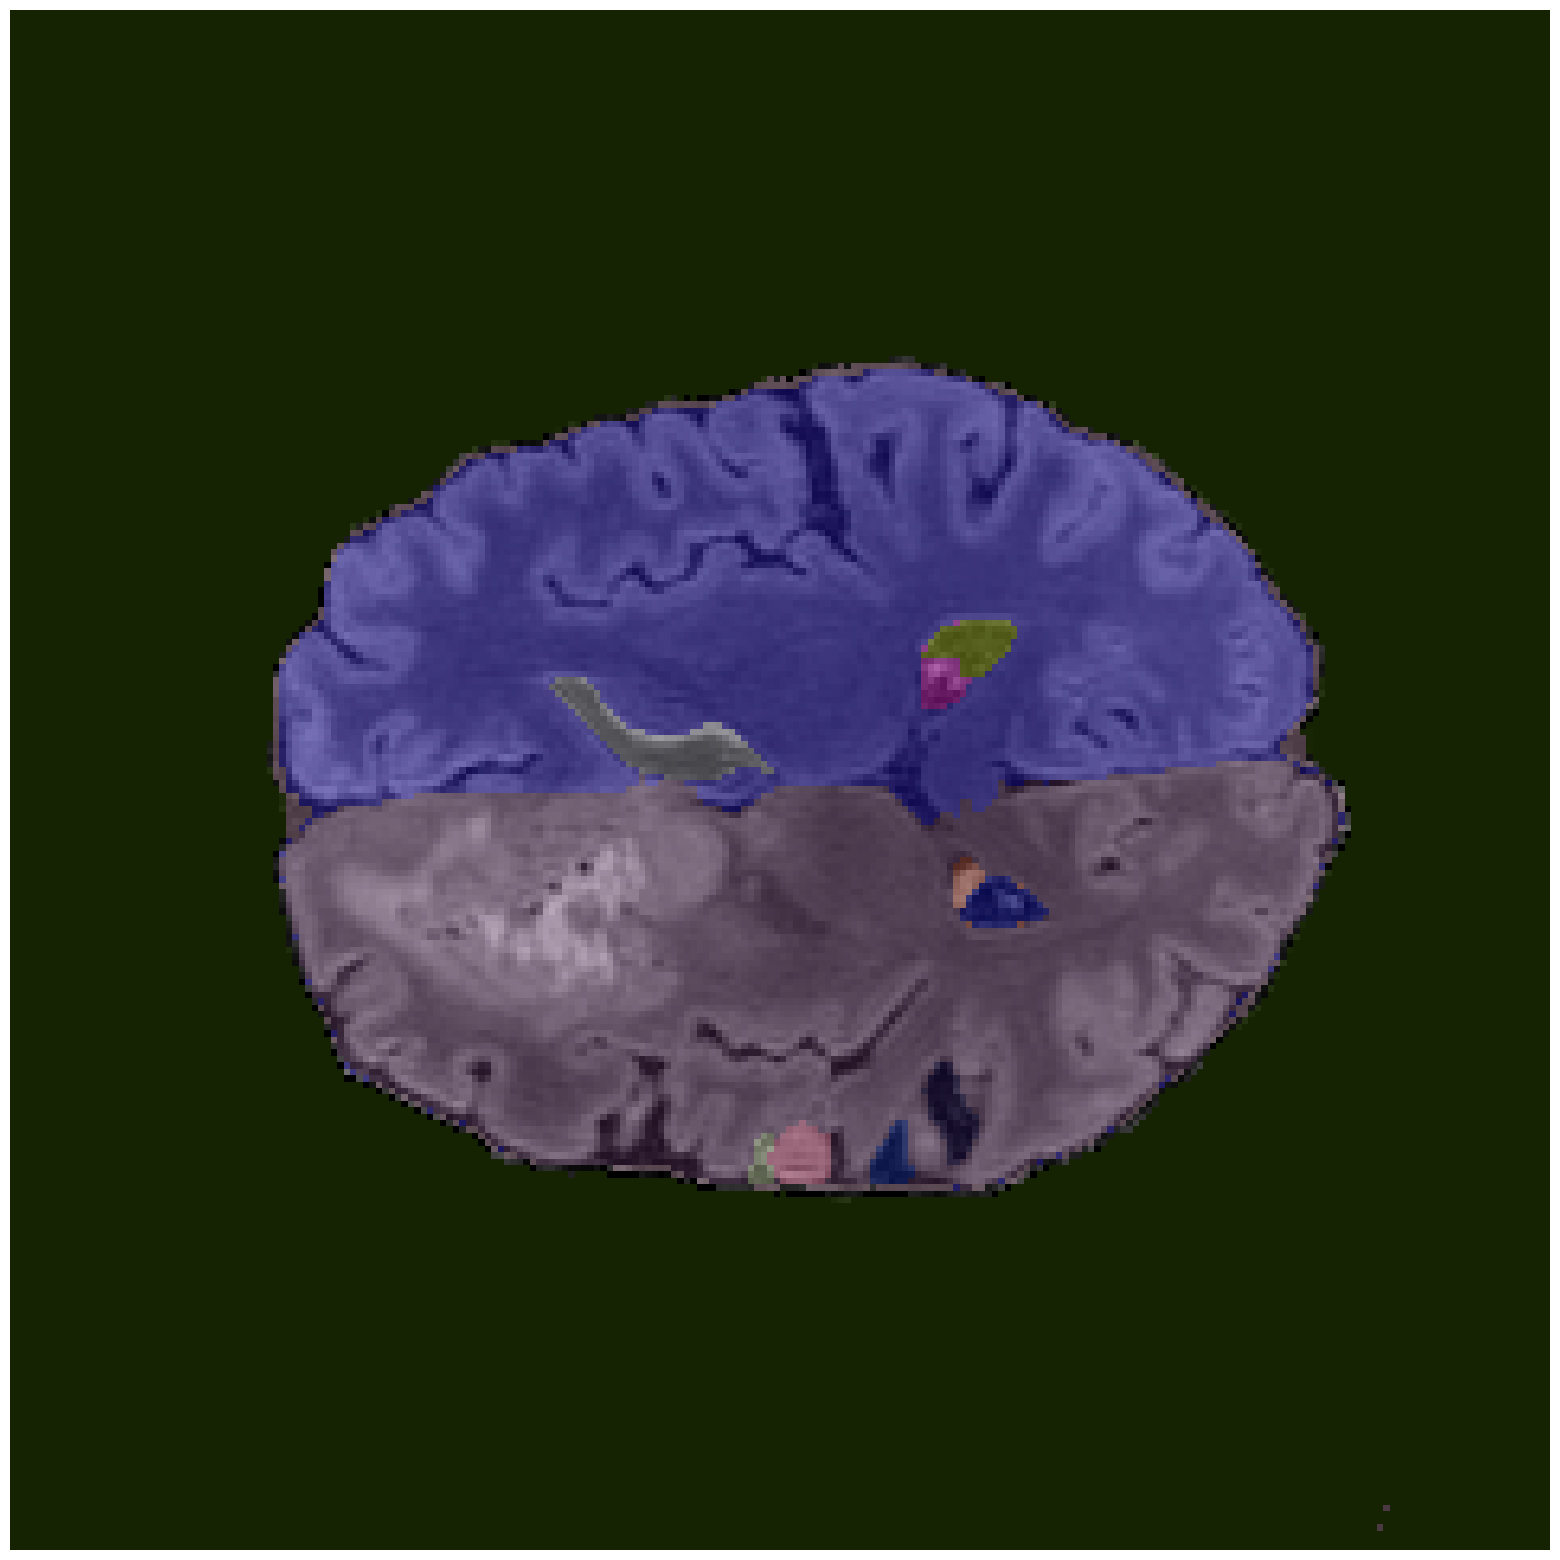

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)


28

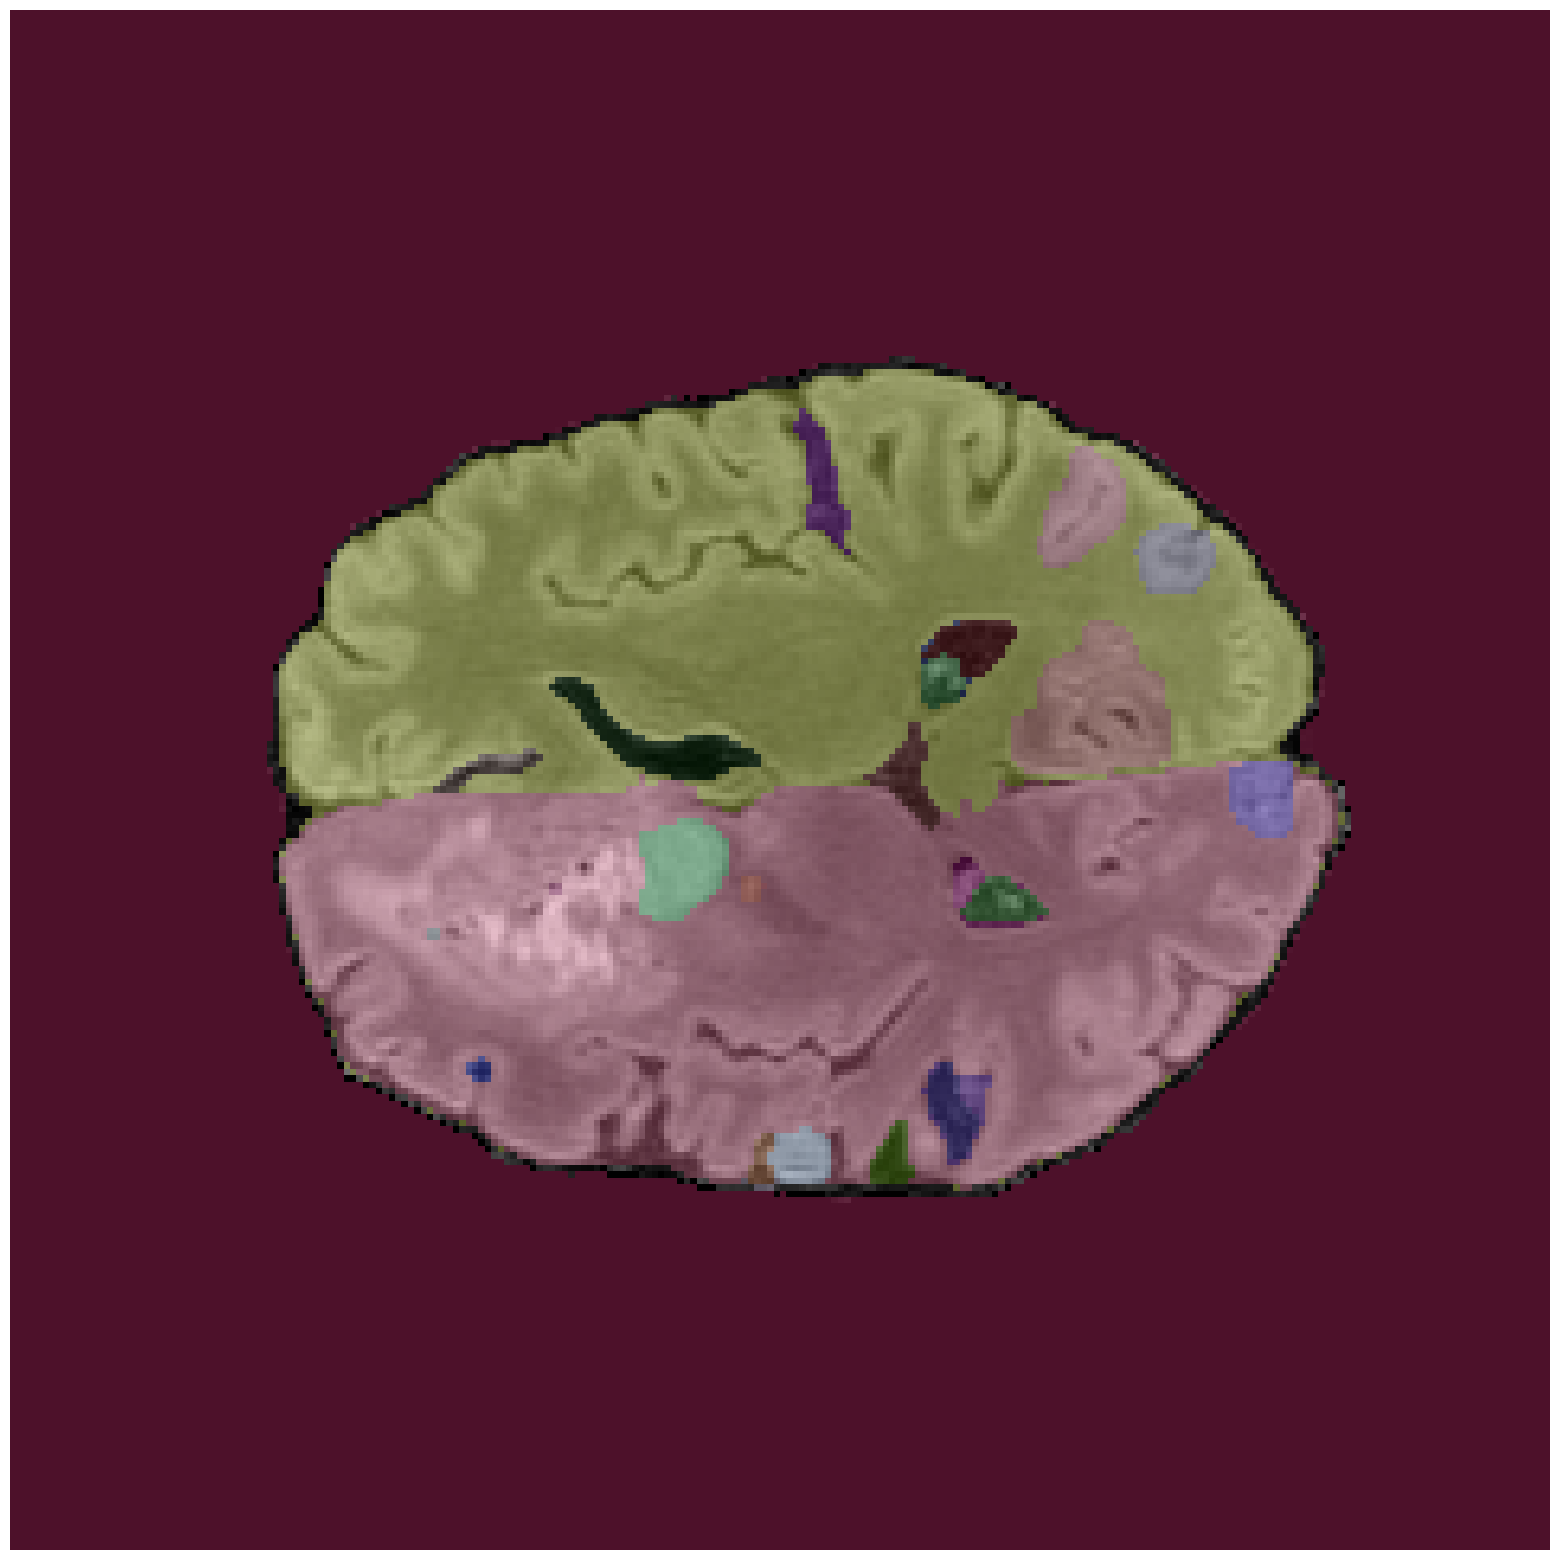

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

### Bounding box on mask

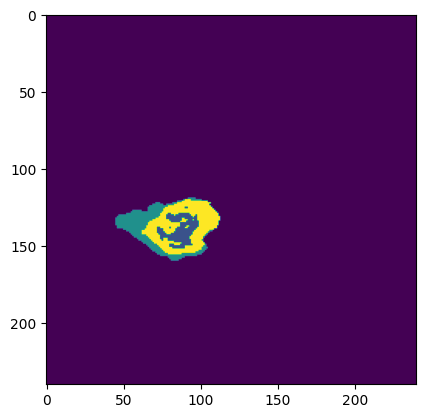

In [ ]:
image_path = "/content/BraTS2021_00000/BraTS2021_00000_flair.nii.gz"
mask_path = "/content/BraTS2021_00000/BraTS2021_00000_seg.nii.gz"


image = nib.load(image_path)
image = image.get_fdata()
min_ = image.min()
max_ = image.max()
image = (image - min_)/(max_ - min_)
image = np.float32(image)


mask = nib.load(mask_path)
mask = mask.get_fdata()
min_ = mask.min()
max_ = mask.max()
mask = (mask - min_)/(max_ - min_)
mask = np.float32(mask)


plt.imshow(mask[:,:,80])

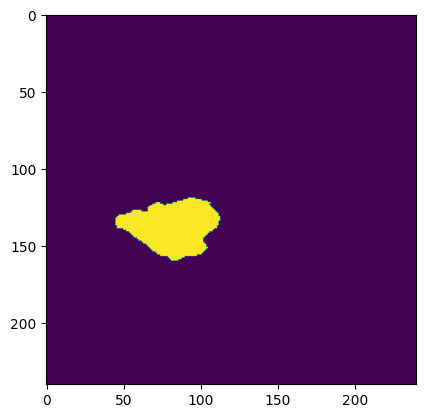

In [ ]:
image = cv2.cvtColor(image[:,:,80], cv2.COLOR_BGR2RGB)
image = image * 255
image = np.uint8(image)


mask = mask[:,:,80]
mask [mask>0] = 1
mask = mask * 255
mask = np.uint8(mask)

plt.imshow(mask)

In [ ]:
x1,y1,w,h = cv2.boundingRect(mask)
x2 = x1+w
y2 = y1+h

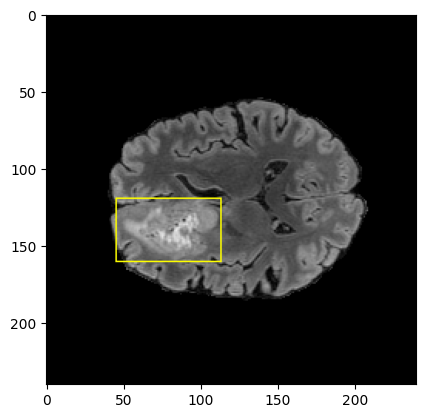

In [ ]:
start = (x1, y1)
end = (x2, y2)
colour = (255, 255, 0)
thickness = 1
rectangle_img = cv2.rectangle(image, start, end, colour, thickness)
plt.imshow(rectangle_img, cmap="gray")


In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

In [ ]:
input_box = np.array([x1, y1, x2, y2])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

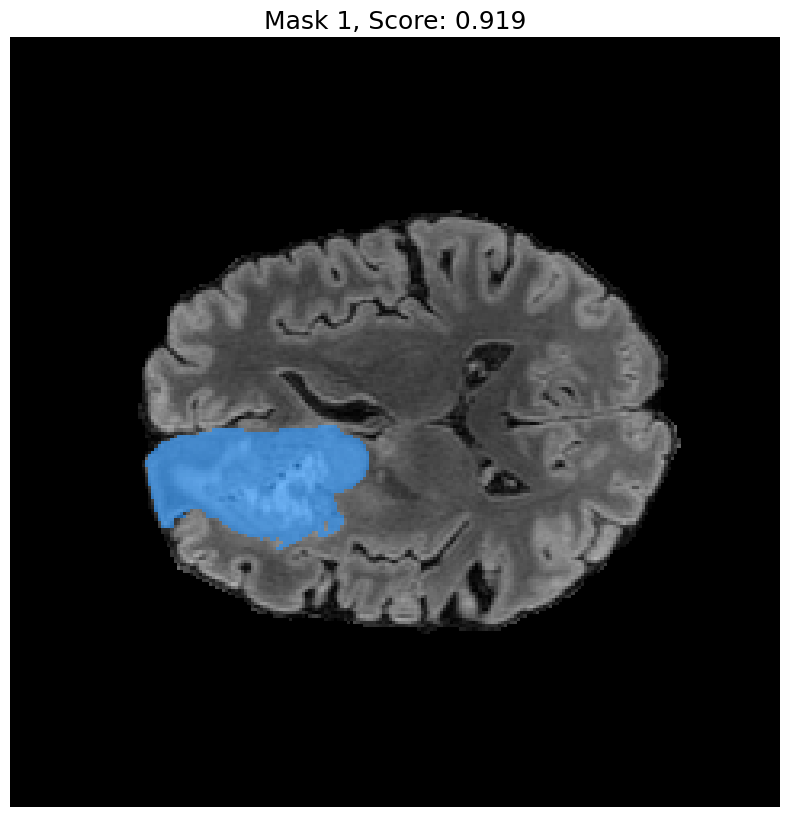

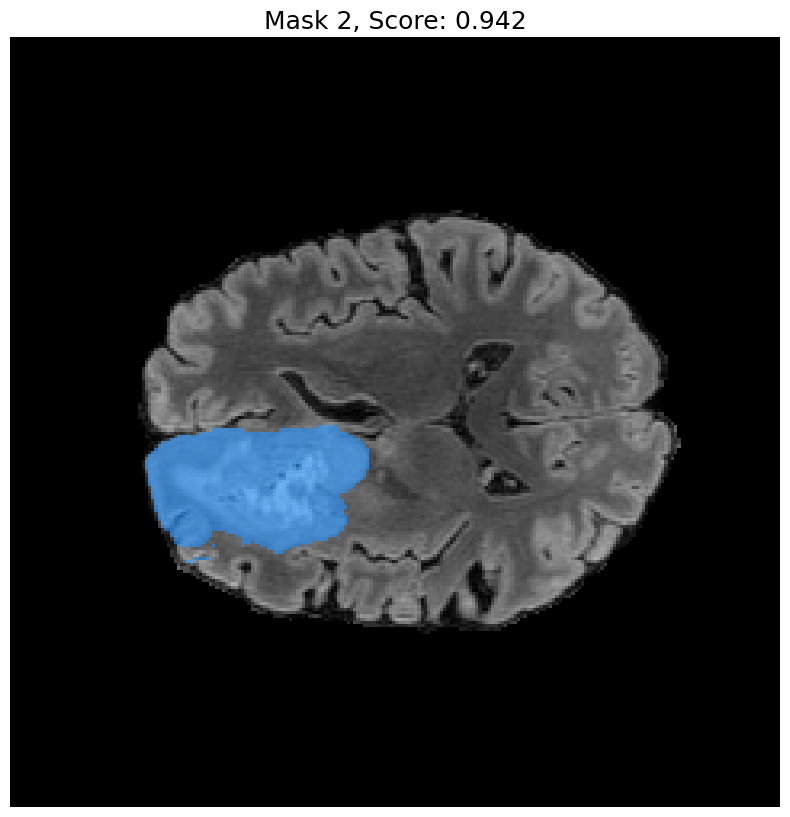

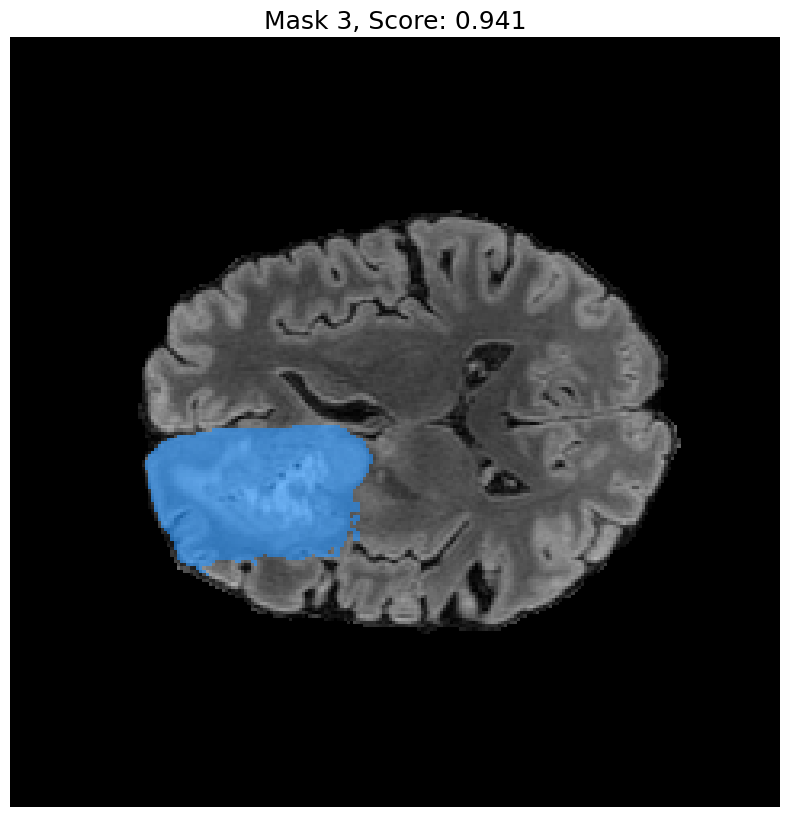

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

## SAM explore

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)


In [ ]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
# raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# input_points = [[[450, 600]]]  # 2D location of a window in the image

# inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# outputs = model(**inputs)

# masks = processor.image_processor.post_process_masks(
#     outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
# 
# scores = outputs.iou_scores

## Quantify SAM

In [13]:
# ! pip install torchmetrics
import torch
from torchmetrics import Dice

# mask = np.array([0, 1,1 ,0,1,1,1])
# output = mask == 1

mask [mask>0] = 1
mask = np.uint8(mask)
mask = torch.from_numpy(mask)

output = output.astype(np.uint8)
output = torch.from_numpy(output)
# print(mask)
# print(output)

dice = Dice()
dice(mask, output)

[0 1 1 0 1 1 1]
[False  True  True False  True  True  True]
tensor([0, 1, 1, 0, 1, 1, 1], dtype=torch.uint8)
tensor([0, 1, 1, 0, 1, 1, 1], dtype=torch.uint8)


tensor(1.)

In [2]:
import numpy as np

y = np.array([False, False,  True,  True])
y.astype(np.uint8)

array([0, 0, 1, 1], dtype=uint8)

In [105]:
def get_bounding_box(mask):
  mask_ = np.copy(mask)
  plt.imshow(mask)
  mask_ [mask_>0] = 1
  mask_ = mask_ * 255
  mask_ = np.uint8(mask_)
  # plt.imshow(mask_)
  # print(mask_.max())

  x1,y1,w,h = cv2.boundingRect(mask_)
  x2 = x1+w
  y2 = y1+h
  
  return (x1, y1, x2, y2)


(77, 58) (180, 142)


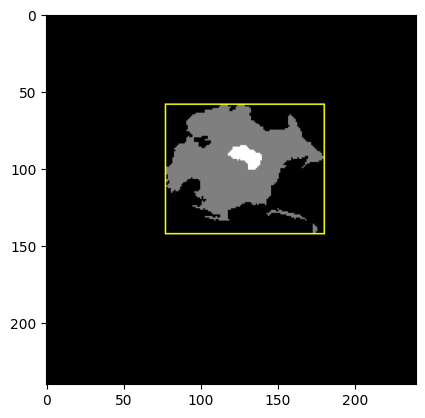

In [108]:
mask = nib.load("/content/BraTS20_Training_001_seg.nii")
mask = mask.get_fdata()

image = nib.load("/content/BraTS20_Training_001_seg.nii")
image = image.get_fdata()
min_ = image.min()
max_ = image.max()
image = (image - min_)/(max_ - min_)
image = np.float32(image)
image = cv2.cvtColor(image[:,:,80], cv2.COLOR_BGR2RGB)
# image = np.stack([image[:,:,80], image[:,:,80], image[:,:,80]], axis=-1)
# print(image.shape)
image = image * 255
image = np.uint8(image)

x1, y1, x2, y2 = get_bounding_box(mask[:,:,80])


start = (x1, y1)
end = (x2, y2)
print(start, end)
colour = (255, 255, 0)
thickness = 1
rectangle_img = cv2.rectangle(image, start, end, colour, thickness)
plt.imshow(rectangle_img, cmap="gray")

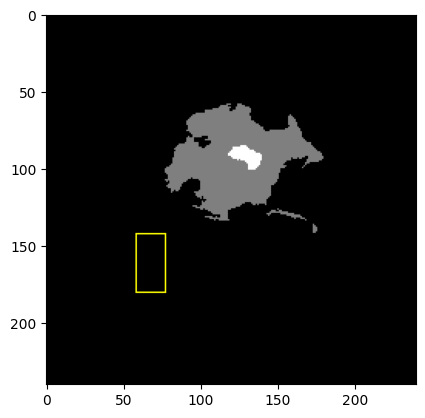

In [62]:
plt.imshow(image)

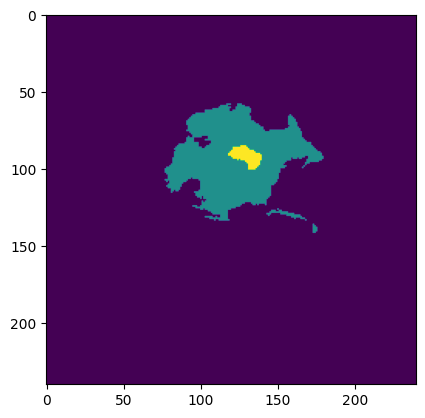

In [63]:
plt.imshow(mask[:,:,80])